In [13]:
from backpack_predictor import prepare_data, target_encoding
from backpack_predictor.features import target, baseline_features, feature_list, cat_cols

%load_ext autoreload
%autoreload 2

from datetime import datetime
import time
import numpy as np
import pandas as pd
from scipy.stats import skew, chisquare, kruskal, ks_2samp, chi2_contingency

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import TargetEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import root_mean_squared_error

# import xgboost as xgb
import lightgbm as lgb

from optuna.integration import LightGBMPruningCallback #XGBoostPruningCallback, CatBoostPruningCallback
import optuna

import warnings
warnings.filterwarnings('ignore')

test_df = pd.read_csv(r'..//data//test.csv')
train_df = pd.read_csv(r'..//data//train.csv')
train_extra_df = pd.read_csv(r'..//data//training_extra.csv')
train_df = pd.concat([train_df, train_extra_df], ignore_index=True)

# Apply function to train and test datasets
train_df = prepare_data(train_df, is_train=True)
test_df = prepare_data(test_df, is_train=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# Add original data
orig_df = pd.read_csv(r'..//data//orig.csv')
orig_df.insert(loc=0, column='id', value=0) # Add id to first col to match new train
orig_df = prepare_data(orig_df, is_train=True)
orig_df.columns = [f"{c}_orig" for c in orig_df.columns]
orig_df_columns = orig_df.columns.to_list()
train_df = train_df.merge(orig_df.loc[(orig_df["weight_capacity_orig"]>5)&(orig_df["weight_capacity_orig"]<30)], left_on='weight_capacity', right_on='weight_capacity_orig', how='left')

In [15]:
model_str = "lgb_"
study_name = 'many_cols_'

In [16]:
import itertools

def create_comb_features(train_df, test_df, cols, allowed_features, comb_size):
    for comb in itertools.combinations(cols, comb_size):
        col_name = "_".join(comb)
        if col_name not in allowed_features:
            continue
        # Create the new feature by joining the selected columns row-wise
        train_df[col_name] = train_df[list(comb)].astype(str).agg('_'.join, axis=1)
        test_df[col_name] = test_df[list(comb)].astype(str).agg('_'.join, axis=1)


best_2 = [
    'material_is_waterproof', 'material_laptop_compartment',
    'material_size', 'material_style', 'is_waterproof_color', 'style_color'
]
best_3 = [
    'material_laptop_compartment_is_waterproof', 'material_laptop_compartment_style',
    'material_is_waterproof_style', 'material_size_laptop_compartment', 'laptop_compartment_is_waterproof_color'
]
best_4 = [
    'material_size_laptop_compartment_is_waterproof', 'material_laptop_compartment_is_waterproof_style',
    'brand_laptop_compartment_is_waterproof_style', 'material_laptop_compartment_is_waterproof_color',
    'brand_material_laptop_compartment_is_waterproof'
]

cols = ['brand', 'material', 'size', 'laptop_compartment', 'is_waterproof', 'style', 'color']
create_comb_features(train_df, test_df, cols, best_2, 2)
create_comb_features(train_df, test_df, cols, best_3, 3)
create_comb_features(train_df, test_df, cols, best_4, 4)

In [17]:
stats = ['mean', 'skew', 'count', 'var']
FOLDS = 3
inner_folds = 10

target_feature_cols = ['weight_capacity', 'compartments', 'laptop_compartment', 'is_waterproof', 'material', 'brand']
target_feature_cols = target_feature_cols + best_2 + best_3 + best_4 + orig_df_columns 
target_feature_sets = {
    f"{col1}": {
        "stats": stats
    }
    for col1 in target_feature_cols
}

all_new_cols = []
for col1, v in target_feature_sets.items():
    new_cols = [f"{col1}_{target}_{stat}" for stat in stats]
    target_feature_sets[col1]['new_cols'] = new_cols
    all_new_cols.extend(new_cols)

feature_sets = {
    'material': {
        'col2_list': ['is_waterproof', 'laptop_compartment', 'style', 'size'],
        'stats': stats,
    },
}
for col1, v in feature_sets.items():
    col2_list = v['col2_list']
    new_cols = [f"{col1}_{col2}_{stat}" for col2 in col2_list for stat in stats]
    feature_sets[col1]['new_cols'] = new_cols
    all_new_cols.extend(new_cols)

features = [
    'weight_capacity', 'compartments', 'laptop_compartment', 'is_waterproof', 'brand', 'color', 'size', 'material', 'style' 
] + all_new_cols + orig_df_columns

print(f"Using {len(features)} features.")

data_splits = []

kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
for i, (train_idx, valid_idx) in enumerate(kf.split(train_df), 1):
    train_fold = train_df.loc[train_idx].reset_index(drop=True)
    valid_fold = train_df.loc[valid_idx].reset_index(drop=True)

    # -----------------------------------------------------
    # Inner K-Fold (for partial target encoding)
    # -----------------------------------------------------
    kf_inner = KFold(n_splits=inner_folds, shuffle=True, random_state=42)
    for j, (inner_train_idx, inner_valid_idx) in enumerate(kf_inner.split(train_fold)):
        inner_train = train_fold.loc[inner_train_idx].copy()
        for col1, v in target_feature_sets.items():
            stats = v['stats']
            new_cols = v['new_cols']
            agg_stats = inner_train.groupby(col1)[target].agg(stats)
            for stat, new_col in zip(stats, new_cols):
                train_fold.loc[inner_valid_idx, new_col] = train_fold.loc[inner_valid_idx, col1].map(agg_stats[stat])

    # -----------------------------------------------------
    # Outer K-Fold Add Feature Sets
    # -----------------------------------------------------
    for col1, v in target_feature_sets.items():
        stats = v['stats']
        new_cols = v['new_cols']
        agg_stats = inner_train.groupby(col1)[target].agg(stats)
        for stat, new_col in zip(stats, new_cols):
            valid_fold.loc[:, new_col] = valid_fold.loc[:, col1].map(agg_stats[stat])

    for col1, v in feature_sets.items():
        stats = v['stats']
        col2_list = v['col2_list']
        new_cols = v['new_cols']
        for k, col2 in enumerate(col2_list):
            agg_stats = inner_train.groupby(col1)[col2].agg(stats)
            for stat, new_col in zip(stats, new_cols[k*len(stats):(k+1)*len(stats)]):
                train_fold.loc[:, new_col] = train_fold.loc[:, col1].map(agg_stats[stat])
                valid_fold.loc[:, new_col] = valid_fold.loc[:, col1].map(agg_stats[stat])

    train_fold[['compartments', 'laptop_compartment', 'is_waterproof', 'brand', 'color', 'size', 'material', 'style']] = \
        train_fold[['compartments', 'laptop_compartment', 'is_waterproof', 'brand', 'color', 'size', 'material', 'style']].astype('category') 
    
    valid_fold[['compartments', 'laptop_compartment', 'is_waterproof', 'brand', 'color', 'size', 'material', 'style']] = \
        valid_fold[['compartments', 'laptop_compartment', 'is_waterproof', 'brand', 'color', 'size', 'material', 'style']].astype('category') 

    data_splits.append((train_fold, valid_fold))

Using 163 features.


In [ ]:
for i, (train_fold, valid_fold) in enumerate(data_splits, 1):
    # Convert object columns to categorical in train fold
    object_cols = train_fold.select_dtypes(include=['object']).columns
    train_fold[object_cols] = train_fold[object_cols].astype('category')
    valid_fold[object_cols] = valid_fold[object_cols].astype('category')

In [23]:
def objective(trial):
    params = {
        'random_state': 42,
        'verbose': -1,  # -1: Fatal, 0: Warning, 1: Info, 2: Debug
        'objective': 'regression',
        'metric': 'rmse',
        'force_row_wise': True,
        # 'early_stopping_rounds': 50, # the {n}th accuracy on the validation set does not improve, stop training
        'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 50, 1000),

        # bagging_fraction is like feature_fraction, but randomly selects data without resampling
        # bagging_freq must be non-zero to enable bagging
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),

        # default = 10.0,  used for the categorical features
        'cat_l2':  trial.suggest_float('cat_l2', 0.01, 100),

        # if set to true, when evaluating node splits LightGBM will check only one randomly-chosen threshold for each feature
        'extra_trees': trial.suggest_categorical("extra_trees", [True, False]),

        # subset of features on each iteration (tree) to select
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        # colsample_bytree is ignored when feature_fraction is set
        # 'colsample_bytree': trial.suggest_float('colsample_bytree', 0.25, 0.35),

        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5, log=True),

        # max number of bins that feature values will be bucketed in
        'max_bin': trial.suggest_int('max_bin', 2, 20000),

        # <= 0 means no limit. Used to deal with over-fitting when data is small. Tree still grows leaf-wise. 
        'max_depth': trial.suggest_int('max_depth', -1, 2000),  

        # Very important to prevent over-fitting. Setting it to hundreds or thousands is enough for a large dataset.
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 100),
        'min_split_gain': 0.5,
        
        'n_estimators': trial.suggest_int('n_estimators', 100, 20000),

        # main parameter to control the complexity of the tree model. Should be smaller than 2^max_depth
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),

        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),

        # subsample is ignored when bagging_fraction is set
        # 'subsample': trial.suggest_float('subsample', 0.2, 0.25),
        
    }


    rmse_list = []
    for i, (train_fold, valid_fold) in enumerate(data_splits, 1):

        train_data = lgb.Dataset(train_fold[features], label=train_fold[target])
        valid_data = lgb.Dataset(valid_fold[features], label=valid_fold[target], reference=train_data)
      
        model = lgb.train(
            params=params,
            train_set=train_data,
            valid_sets=[train_data, valid_data],
            valid_names=['train_0', 'valid_0'],
            callbacks=[
                LightGBMPruningCallback(trial, "rmse", valid_name="valid_0"),
                lgb.log_evaluation(-1)                   # Suppress training logs
            ]
        )
        y_pred = model.predict(valid_fold[features], num_iteration=model.best_iteration)
        rmse = root_mean_squared_error(valid_fold[target], y_pred)
        rmse_list.append(rmse)

    return np.mean(rmse_list)

study = optuna.create_study(
        storage=f"sqlite:///..//optuna//{model_str}db.sqlite3",
        study_name=model_str + study_name + datetime.now().strftime("%Y-%m-%d_%H-%M"),
        direction="minimize"
)
study.optimize(objective, n_trials=1000)

print("\n=========================")
print("Number of finished trials:", len(study.trials))
print("Best trial:", study.best_trial.number)
print("Best value (RMSE):", study.best_trial.value)
print("Best hyperparameters:", study.best_trial.params)
best_params = study.best_trial.params
best_params["random_state"] = 42
best_params["verbose"] = 0
best_params["metric"] = "rmse"
best_params["force_row_wise"] = True

[I 2025-02-25 05:45:11,539] A new study created in RDB with name: lgb_many_cols_2025-02-25_05-45
[I 2025-02-25 05:53:42,415] Trial 0 finished with value: 38.712893957872474 and parameters: {'early_stopping_rounds': 908, 'bagging_fraction': 0.4684787489405777, 'bagging_freq': 1, 'cat_l2': 18.534290505769754, 'extra_trees': False, 'feature_fraction': 0.6502028714373068, 'learning_rate': 0.3088579815773508, 'max_bin': 15681, 'max_depth': 728, 'min_samples_leaf': 5, 'n_estimators': 569, 'num_leaves': 186, 'lambda_l1': 6.852316312953273e-06, 'lambda_l2': 0.015114969623557652}. Best is trial 0 with value: 38.712893957872474.
[I 2025-02-25 05:56:27,584] Trial 1 finished with value: 38.68704396795531 and parameters: {'early_stopping_rounds': 341, 'bagging_fraction': 0.7263227314148035, 'bagging_freq': 7, 'cat_l2': 40.37100201262069, 'extra_trees': False, 'feature_fraction': 0.5508767705839874, 'learning_rate': 0.14537058137021383, 'max_bin': 1577, 'max_depth': 608, 'min_samples_leaf': 47, 'n_e


Number of finished trials: 1000
Best trial: 3
Best value (RMSE): 38.68325342233416
Best hyperparameters: {'early_stopping_rounds': 418, 'bagging_fraction': 0.9693585229391997, 'bagging_freq': 6, 'cat_l2': 61.44378580242574, 'extra_trees': False, 'feature_fraction': 0.6724276326440947, 'learning_rate': 0.14325247208979894, 'max_bin': 17270, 'max_depth': 759, 'min_samples_leaf': 6, 'n_estimators': 13801, 'num_leaves': 73, 'lambda_l1': 8.5927760223075e-06, 'lambda_l2': 1.1352504543890287e-06}


In [24]:
best_params

{'early_stopping_rounds': 418,
 'bagging_fraction': 0.9693585229391997,
 'bagging_freq': 6,
 'cat_l2': 61.44378580242574,
 'extra_trees': False,
 'feature_fraction': 0.6724276326440947,
 'learning_rate': 0.14325247208979894,
 'max_bin': 17270,
 'max_depth': 759,
 'min_samples_leaf': 6,
 'n_estimators': 13801,
 'num_leaves': 73,
 'lambda_l1': 8.5927760223075e-06,
 'lambda_l2': 1.1352504543890287e-06,
 'random_state': 42,
 'verbose': 0,
 'metric': 'rmse',
 'force_row_wise': True}

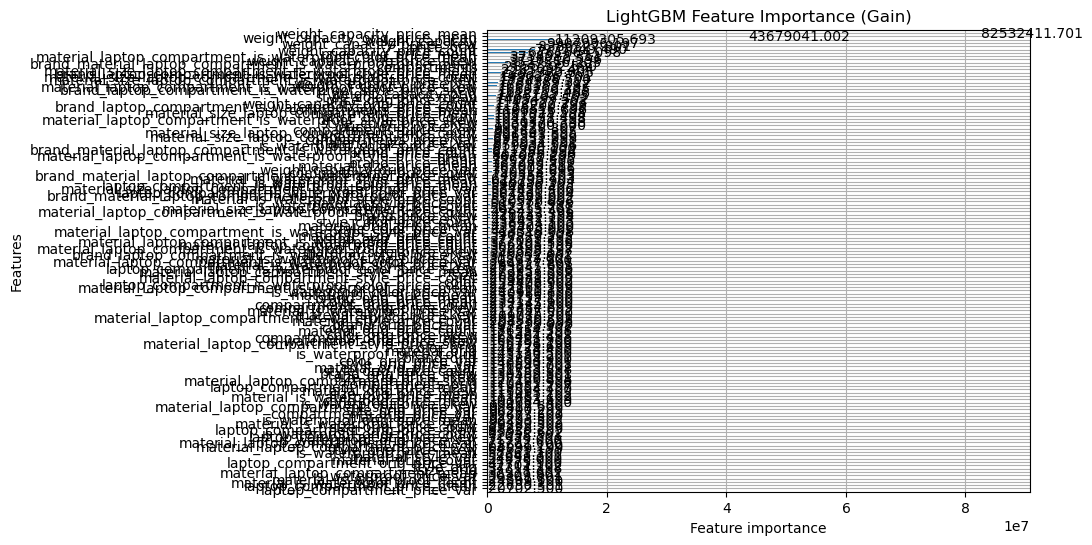

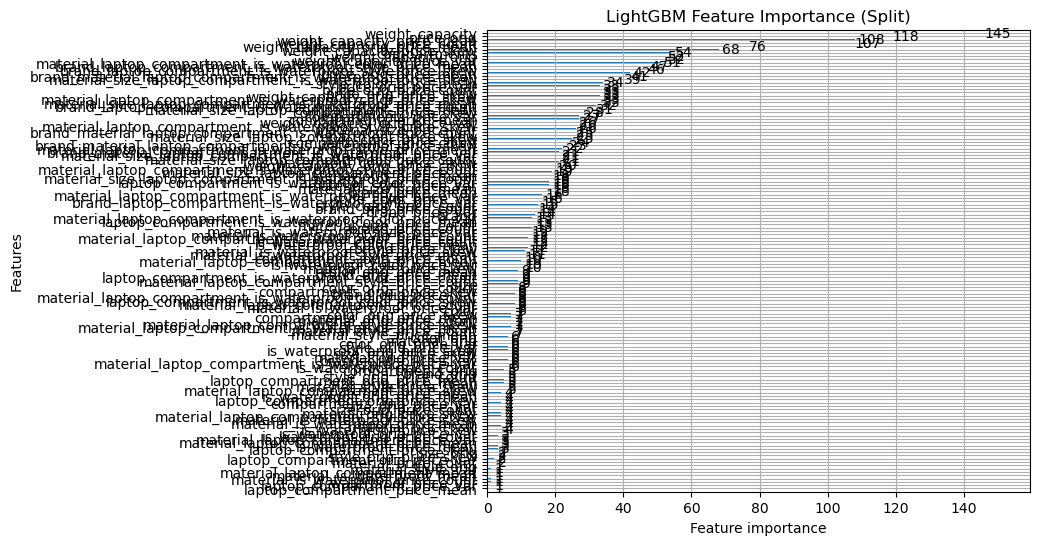

In [25]:
for i, (train_fold, valid_fold) in enumerate(data_splits, 1):

    train_data = lgb.Dataset(train_fold[features], label=train_fold[target])
    valid_data = lgb.Dataset(valid_fold[features], label=valid_fold[target], reference=train_data)
    break

model = lgb.train(params=best_params, train_set=train_data, valid_sets=[train_data, valid_data])

lgb.plot_importance(model, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()

lgb.plot_importance(model, importance_type="split", figsize=(7,6), title="LightGBM Feature Importance (Split)")
plt.show()

In [ ]:
feature_importance_split = model.feature_importance(importance_type='split')
feature_importance_gain = model.feature_importance(importance_type='gain')

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': features,
    'Split Importance': feature_importance_split,
    'Gain Importance': feature_importance_gain
}).sort_values(by='Gain Importance', ascending=False)
importance_df

,Feature,Split Importance,Gain Importance
9,weight_capacity_price_mean,108,8.253241e+07
129,weight_capacity_orig_price_mean,76,4.367904e+07
0,weight_capacity,145,1.120931e+07
10,weight_capacity_price_skew,68,9.907996e+06
162,price_orig,118,8.386328e+06
...,...,...,...
138,material_is_waterproof_skew,0,0.000000e+00
8,style,0,0.000000e+00
3,is_waterproof,0,0.000000e+00
2,laptop_compartment,0,0.000000e+00


In [47]:
split_lower = importance_df['Split Importance'].quantile(.5), 
gain_lower = importance_df['Gain Importance'].quantile(.5)

# Features to remove based on conditions
features_to_remove = importance_df[
    (importance_df['Split Importance'] < split_lower) & 
    (importance_df['Gain Importance'] < gain_lower)
]['Feature'].to_list()

# Remove them from the 'features' list
filtered_features = [feature for feature in features if feature not in features_to_remove]

# Display the updated features list
print(len(filtered_features), "of", len(features))

87 of 163


In [48]:
def objective(trial):
    params = {
        'random_state': 42,
        'verbose': -1,  # -1: Fatal, 0: Warning, 1: Info, 2: Debug
        'objective': 'regression',
        'metric': 'rmse',
        'force_row_wise': True,
        # 'early_stopping_rounds': 50, # the {n}th accuracy on the validation set does not improve, stop training
        'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 50, 1000),

        # bagging_fraction is like feature_fraction, but randomly selects data without resampling
        # bagging_freq must be non-zero to enable bagging
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),

        # default = 10.0,  used for the categorical features
        'cat_l2':  trial.suggest_float('cat_l2', 0.01, 100),

        # if set to true, when evaluating node splits LightGBM will check only one randomly-chosen threshold for each feature
        'extra_trees': trial.suggest_categorical("extra_trees", [True, False]),

        # subset of features on each iteration (tree) to select
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        # colsample_bytree is ignored when feature_fraction is set
        # 'colsample_bytree': trial.suggest_float('colsample_bytree', 0.25, 0.35),

        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5, log=True),

        # max number of bins that feature values will be bucketed in
        'max_bin': trial.suggest_int('max_bin', 2, 20000),

        # <= 0 means no limit. Used to deal with over-fitting when data is small. Tree still grows leaf-wise. 
        'max_depth': trial.suggest_int('max_depth', -1, 2000),  

        # Very important to prevent over-fitting. Setting it to hundreds or thousands is enough for a large dataset.
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 100),
        'min_split_gain': 0.5,
        
        'n_estimators': trial.suggest_int('n_estimators', 100, 20000),

        # main parameter to control the complexity of the tree model. Should be smaller than 2^max_depth
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),

        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),

        # subsample is ignored when bagging_fraction is set
        # 'subsample': trial.suggest_float('subsample', 0.2, 0.25),
        
    }


    rmse_list = []
    for i, (train_fold, valid_fold) in enumerate(data_splits, 1):

        train_data = lgb.Dataset(train_fold[filtered_features], label=train_fold[target])
        valid_data = lgb.Dataset(valid_fold[filtered_features], label=valid_fold[target], reference=train_data)
      
        model = lgb.train(
            params=params,
            train_set=train_data,
            valid_sets=[train_data, valid_data],
            valid_names=['train_0', 'valid_0'],
            callbacks=[
                LightGBMPruningCallback(trial, "rmse", valid_name="valid_0"),
                lgb.log_evaluation(-1)                   # Suppress training logs
            ]
        )
        y_pred = model.predict(valid_fold[filtered_features], num_iteration=model.best_iteration)
        rmse = root_mean_squared_error(valid_fold[target], y_pred)
        rmse_list.append(rmse)

    return np.mean(rmse_list)

study = optuna.create_study(
        storage=f"sqlite:///..//optuna//{model_str}db.sqlite3",
        study_name=model_str + study_name + datetime.now().strftime("%Y-%m-%d_%H-%M"),
        direction="minimize"
)
study.optimize(objective, n_trials=1000)

print("\n=========================")
print("Number of finished trials:", len(study.trials))
print("Best trial:", study.best_trial.number)
print("Best value (RMSE):", study.best_trial.value)
print("Best hyperparameters:", study.best_trial.params)
best_params = study.best_trial.params
best_params["random_state"] = 42
best_params["verbose"] = 0
best_params["metric"] = "rmse"
best_params["force_row_wise"] = True

[I 2025-02-25 11:15:52,296] A new study created in RDB with name: lgb_many_cols_2025-02-25_11-15
[I 2025-02-25 11:20:16,569] Trial 0 finished with value: 38.69205734384911 and parameters: {'early_stopping_rounds': 389, 'bagging_fraction': 0.823407799106923, 'bagging_freq': 4, 'cat_l2': 11.590516546276971, 'extra_trees': True, 'feature_fraction': 0.9341173848486908, 'learning_rate': 0.15760268769776972, 'max_bin': 7932, 'max_depth': 338, 'min_samples_leaf': 34, 'n_estimators': 3021, 'num_leaves': 178, 'lambda_l1': 0.029157887203597754, 'lambda_l2': 7.765454374416812e-07}. Best is trial 0 with value: 38.69205734384911.
[I 2025-02-25 11:26:35,949] Trial 1 finished with value: 38.682500516417925 and parameters: {'early_stopping_rounds': 617, 'bagging_fraction': 0.6095619535234815, 'bagging_freq': 4, 'cat_l2': 99.85947773905427, 'extra_trees': False, 'feature_fraction': 0.8243569856329833, 'learning_rate': 0.06079225893935623, 'max_bin': 8051, 'max_depth': 1469, 'min_samples_leaf': 66, 'n_e


Number of finished trials: 1000
Best trial: 4
Best value (RMSE): 38.67998167900614
Best hyperparameters: {'early_stopping_rounds': 665, 'bagging_fraction': 0.9521407990946967, 'bagging_freq': 2, 'cat_l2': 45.02770205248685, 'extra_trees': True, 'feature_fraction': 0.7267456974632711, 'learning_rate': 0.01972629838017322, 'max_bin': 12673, 'max_depth': 1881, 'min_samples_leaf': 38, 'n_estimators': 10901, 'num_leaves': 199, 'lambda_l1': 4.1129438653497346, 'lambda_l2': 7.959598800845867e-06}


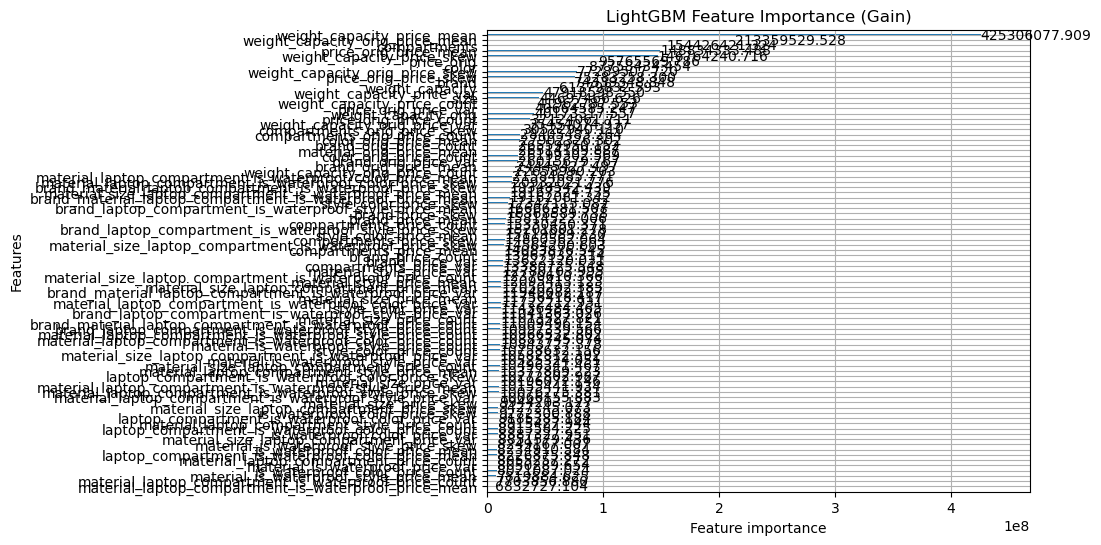

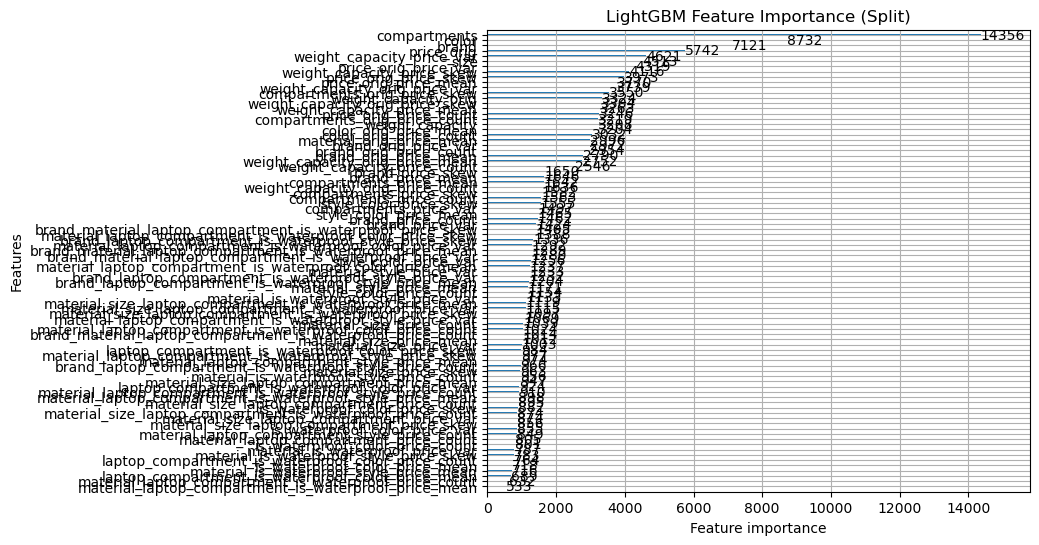

In [50]:
for i, (train_fold, valid_fold) in enumerate(data_splits, 1):

    train_data = lgb.Dataset(train_fold[filtered_features], label=train_fold[target])
    valid_data = lgb.Dataset(valid_fold[filtered_features], label=valid_fold[target], reference=train_data)
    break

model = lgb.train(params=best_params, train_set=train_data, valid_sets=[train_data, valid_data])

lgb.plot_importance(model, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()

lgb.plot_importance(model, importance_type="split", figsize=(7,6), title="LightGBM Feature Importance (Split)")
plt.show()